In [14]:
# !pip install -r ../input/requirements/requirements.txt

# Imports

In [15]:
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.model_selection import train_test_split

from typing import Optional, List, Dict, Union, Tuple
from datetime import datetime
from tqdm.auto import tqdm
import re
import os

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    BertForSequenceClassification, 
    BertConfig,
    DataCollatorWithPadding
)
from transformers.modeling_outputs import SequenceClassifierOutput

# Utilities

## Hyper-Parameters

In [16]:
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name(0)}")
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

MODEL_CHECKPOINT = "dbmdz/bert-base-italian-xxl-cased"

WITH_TOKEN_TYPE_IDS = True
WITH_SEP_TOKENS = True

TRAIN_MODE = "train_no_optuna"
# TRAIN_MODE = "train_with_optuna"
TEST_MODE = "test_no_optuna"
# TEST_MODE = "test_with_optuna"

NUM_WORKERS = 4

SAVE_TOTAL_LIMIT = 3
TEST_SIZE = 0.2
BATCH_SIZE = 2
NUM_EPOCHS = 2
GRADIENT_ACCUMULATION_STEPS = 8
EARLY_STOPPING_PATIENCE = 2
WARMUP_PERCENTAGE = 0.1
WEIGHT_DECAY = 0.01 # int the 0 to 0.1 range
BODY_LR = 3e-5
HEAD_LR = 1.5e-4

OPTUNA_TRAIN_TRIALS=2
OPTUNA_TEST_TRIALS=2
PRUNER_WARMUP_STEPS=2

Using device: NVIDIA GeForce RTX 3060 Laptop GPU


## Paths Settings

In [17]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# ==== LOCAL SETTINGS ====
PATH = os.path.join(".", "out", "datasets", "cipv-chats-toxicity", "chats") # , "gen2", "chats"
OUT_DIR = os.path.join(".", "out", "models", "BERT", timestamp)

# ==== KAGGLE SETTINGS ====
# PATH = os.path.join(os.sep, "kaggle", "input", "cipv-chats-sentiment")
# OUT_DIR = os.path.join(os.sep, "kaggle", "working", timestamp)

RESULTS_PATH = os.path.join(OUT_DIR, "results")
os.makedirs(RESULTS_PATH, exist_ok=True)

## Kaggle Specific Settings

In [18]:
# os.listdir(os.path.join(os.sep, "kaggle", "working"))

In [19]:
# zip_file_path = "/kaggle/working/out-EuclideanLoss-MSELoss-single_sep_False"
# shutil.make_archive(zip_file_path, 'zip', zip_file_path)
# shutil.rmtree(zip_file_path)
# os.remove(zip_file_path + '.zip')

## Plots Utilities

In [20]:
def plot_losses(log_history, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    # Extract logs with 'epoch', 'loss', and 'eval_loss'
    train_logs = [log for log in log_history if 'epoch' in log and 'loss' in log]
    eval_logs = [log for log in log_history if 'epoch' in log and 'eval_loss' in log]

    # Convert to DataFrames for easy grouping
    train_df = DataFrame(train_logs)
    eval_df = DataFrame(eval_logs)

    # Group by epoch and compute mean loss per epoch
    train_epoch_loss = train_df.groupby('epoch')['loss'].mean()
    eval_epoch_loss = eval_df.groupby('epoch')['eval_loss'].mean()

    plt.figure(figsize=(7, 5))
    plt.plot(train_epoch_loss.index, train_epoch_loss.values, 'g-o', label='Train Loss')
    plt.plot(eval_epoch_loss.index, eval_epoch_loss.values, 'c-o', label='Eval Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "learning_curve.png"))
    plt.show()
    plt.close()

# Model Implementation

In [21]:
class BertForRegression(BertForSequenceClassification):
    """
    A BERT regression model that leverages the pretrained classifier head.

    Instead of replacing the original classifier, this model keeps it and adds
    a new linear layer on top (`self.regression_head`). This allows the model
    to use the features learned by the original classification head for the new
    regression task.

    The final output is passed through a Tanh function in the forward pass to
    squash the polarity prediction to the [-1, 1] range.

    This model is fully compatible with the Hugging Face Trainer API.
    """

    def __init__(self, config: BertConfig, cls_token_id: int = None):
        super().__init__(config)
        if cls_token_id is None:
            raise ValueError("cls_token_id must be provided to identify the CLS token in input_ids.")
        self.cls_token_id = cls_token_id

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        # output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        """
        Forward pass for the regression model.

        Args:
            labels (`torch.FloatTensor` of shape `(batch_size,)`, *optional*):
                Labels for computing the Mean Squared Error regression loss.

        Returns:
            `transformers.modeling_outputs.SequenceClassifierOutput`: An object
            containing the loss (if labels are provided), logits (the final
            polarity predictions), hidden states, and attentions.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Step 1: Get the standard BERT model outputs
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=True,  # output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs.hidden_states  # tuple: (layer0, layer1, ..., last_layer)
        last_hidden_state = hidden_states[-1]  # shape: (batch_size, seq_len, hidden_size)
        cls_mask = (input_ids == self.cls_token_id)  # shape: (batch_size, seq_len)

        # Step 2: Pass through the original dropout and classifier layers
        # This leverages the pretrained classifier as a feature extractor.
        output = self.dropout(last_hidden_state[cls_mask])
        output = self.classifier(output)
        logits = torch.tanh(output).squeeze()

        loss = None
        if labels is not None:
            # Flatten labels and create a mask for non-padded labels
            flat_labels = labels.view(-1)
            label_mask = flat_labels != -100
            
            # Filter both logits and labels to only include non-padded items
            # The number of True values in cls_mask should equal the number of non-padded labels
            filtered_logits = logits
            filtered_labels = flat_labels[label_mask]

            # Ensure the number of predictions matches the number of valid labels
            # if filtered_logits.shape[0] != filtered_labels.shape[0]:
            #     raise RuntimeError(
            #         f"Mismatch between number of CLS tokens ({filtered_logits.shape[0]}) "
            #         f"and non-padded labels ({filtered_labels.shape[0]}). "
            #         "Check data collator and input data."
            #     )

            loss = F.mse_loss(filtered_logits, filtered_labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

class DataCollatorForPolarity(DataCollatorWithPadding):
    """
    Data collator for polarity regression tasks.

    This collator extends DataCollatorWithPadding to handle a 'polarity' field
    in the input features. It extracts the polarity values, converts them to a
    torch.FloatTensor, and adds them to the batch dictionary under the key 'labels'.

    This makes it compatible with models that expect a `labels` argument for
    loss calculation, such as the `BertForRegression` model.
    """
    def __init__(self, tokenizer, padding=True, max_length=None, pad_to_multiple_of=None):
        super().__init__(tokenizer, padding=padding, max_length=max_length, pad_to_multiple_of=pad_to_multiple_of)

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        """
        Collates a batch of features.

        Args:
            features (List[Dict[str, Union[List[int], torch.Tensor]]]): A list of
                feature dictionaries. Each dictionary must contain tokenized inputs
                (e.g., 'input_ids') and a 'polarity' key with a float value.

        Returns:
            Dict[str, torch.Tensor]: A dictionary containing the padded batch of
                inputs and a 'labels' tensor.
        """
        # Separate the polarities from the features that need padding
        label_tensors = [feature.pop("labels") for feature in features]
        
        # Use the parent class to handle padding of 'input_ids', 'attention_mask', etc.
        batch = super().__call__(features)
        
        padded_labels = pad_sequence(
            label_tensors,
            batch_first=True,
            padding_value=-100  # Standard ignore_index for loss calculation
        )
            
        batch["labels"] = torch.tensor(padded_labels, dtype=torch.float)
        
        return batch


# Loading the Dataset

In [22]:
def simple_add(dataset, messages, couple_dir):
    all_names = [msg.group("name") for msg in messages]
    if WITH_TOKEN_TYPE_IDS:
        unique_names = list(set(all_names))
        all_messages = [ f"[{unique_names.index(all_names[i])}]" + msg.group("name_content") for i, msg in enumerate(messages)]
        if WITH_SEP_TOKENS:
            input_chat = ("[CLS][SEP]" + "\n").join(all_messages) + "[CLS]"
        else:
            input_chat = ("[CLS]" + "\n").join(all_messages) + "[CLS]"
    else:
        input_chat = ("[CLS]" + "\n").join(all_messages) + "[CLS]"


    dataset['chats'].append(input_chat)
    dataset['polarities'].append([float(msg.group("polarity")) for msg in messages])
    dataset['user_ids'].append(couple_dir)
    dataset['msgs_lengths'].append(len(messages))

def load_dataset(path):
    # msgs_regex = re.compile(r"(?P<message>(?P<timestamp>\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d) \|? ?(?P<name_content>(?P<name>.+):\n(?P<content>.+))\n+Polarity: (?P<polarity>[-+]?\d\.?\d?\d?)\n\[(?P<tag_explanation>(?P<tag>Tag: .+)\n?Spiegazione: (?P<explanation>.+))\])")
    msgs_regex = re.compile(r"(?P<message>\(?(?P<timestamp>\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d)\)? ?\|? ?(?P<name_content>(?P<name>.+):\n?\s?(?P<content>.+))\n?\s?Polarity: (?P<polarity>(?:-?|\+?)\d\.?\d?\d?))")
    dataset = {
        "chats": [],
        "polarities": [],
        "user_ids": [],
        "msgs_lengths": [],
    }
    skipped = 0
    model_dirs = os.listdir(path)
    for model_dir in tqdm(model_dirs, desc="📂 Loading Dataset"):
        model_dir_path = os.path.join(path, model_dir)
        couple_dirs = os.listdir(model_dir_path)
        for couple_dir in tqdm(couple_dirs, desc=f"📂 Loading Directory: {model_dir_path}"):
            couple_dir_path = os.path.join(model_dir_path, couple_dir)
            files = os.listdir(couple_dir_path)
            for file in files:
                with open(os.path.join(couple_dir_path, file), "r", encoding="utf-8") as f:
                    chat = f.read()
                    messages = list(msgs_regex.finditer(chat))
                    if len(messages) > 0: # checks if there are matched messages
                        simple_add(dataset, messages, couple_dir)
                    else:
                        skipped += 1
                        print(f"No messages found in file: {os.path.join(couple_dir_path, file)}")
                        
    return dataset, skipped

dataset, skipped = load_dataset(PATH)
dataset = Dataset.from_dict(dataset)
print(f"Skipped: {skipped}")

📂 Loading Dataset:   0%|          | 0/11 [00:00<?, ?it/s]

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.0-flash-dataset_2025-07-09-15-56-22:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-07-10-45-16:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-08-20-06-22:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-16-09-07-33:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-19-14-42-59:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-lite-preview-06-17-dataset_2025…

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash_2025-08-01-16-58-50:   0%|     …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash_2025-08-02-14-18-13:   0%|     …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash_2025-08-03-13-30-47:   0%|     …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-pro_2025-08-01-17-25-51:   0%|       …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-pro_2025-08-02-12-42-24:   0%|       …

Skipped: 0


In [23]:
def print_dataset_info(dataset):
    print(dataset)
    # For each field, print the first entry
    for field in dataset.features:
        print(f"{field}: {dataset[0][field]}\n")

print_dataset_info(dataset)

Dataset({
    features: ['chats', 'polarities', 'user_ids', 'msgs_lengths'],
    num_rows: 3157
})
chats: [0]Sofia:
Ciao Marco, come stai?[CLS][SEP]
[1]Marco:
Ciao Sofia. Tutto bene, grazie. Un po' impegnato con il lavoro.[CLS][SEP]
[0]Sofia:
Capisco. Senti, volevo dirti che questa settimana ho bisogno di un po' di spazio. Sono molto stressata e ho bisogno di concentrarmi su me stessa.[CLS][SEP]
[1]Marco:
Ah, ok. Quindi cosa significa? Non vuoi che ti scriva o ti chiami?[CLS][SEP]
[0]Sofia:
Significa che ho bisogno di tempo per me stessa, per rilassarmi e ricaricare le energie. Possiamo sentirci, ma magari non tutti i giorni e non per parlare di cose impegnative. Ho bisogno di leggerezza.[CLS][SEP]
[1]Marco:
Va bene. Cercherò di rispettare il tuo bisogno. Ma sappi che mi mancherai.[CLS][SEP]
[0]Sofia:
Grazie Marco, lo apprezzo molto. Anche tu mi mancherai, ma so che questo è necessario per il nostro benessere.[CLS][SEP]
[1]Marco:
Ok. Allora ci sentiamo tra qualche giorno. Buona giornat

# Pre-Processing the Dataset

In [24]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
if WITH_TOKEN_TYPE_IDS:
    tokenizer.add_special_tokens({
        "additional_special_tokens": ["[0]", "[1]"]
    })
    id_0 = tokenizer.convert_tokens_to_ids("[0]")
    id_1 = tokenizer.convert_tokens_to_ids("[1]")
    print(f"Special tokens added: {id_0} for [0], {id_1} for [1]")

def preprocess(examples):
    tokenized_chats = tokenizer(
        examples['chats'],
        # padding='max_length',
        # truncation=True,
        # max_length=1024,
        # return_tensors='pt',
        add_special_tokens=False # Skip special tokens in the target text
    )
    tokenized_chats["labels"] = examples["polarities"]
    tokenized_chats["user_ids"] = examples["user_ids"]
    tokenized_chats["msgs_lengths"] = examples["msgs_lengths"]

    if WITH_TOKEN_TYPE_IDS:
        tkn_type = 0  # Default token type
        for i, sample in enumerate(tokenized_chats['input_ids']):
            for j, tkn in enumerate(sample):
                if tkn == id_0:
                    tkn_type = 0
                    # remove the special token at current position
                    tokenized_chats['input_ids'][i].pop(j)
                    tokenized_chats['attention_mask'][i].pop(j)
                    tokenized_chats['token_type_ids'][i].pop(j)
                elif tkn == id_1:
                    tkn_type = 1
                    # remove the special token at current position
                    tokenized_chats['input_ids'][i].pop(j)
                    tokenized_chats['attention_mask'][i].pop(j)
                    tokenized_chats['token_type_ids'][i].pop(j)
                tokenized_chats['token_type_ids'][i][j] = tkn_type

    return tokenized_chats

tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    # batch_size=1000,
    remove_columns=dataset.column_names
)
print_dataset_info(tokenized_dataset)
# print(tokenized_dataset)

# remove the special tokens from the tokenizer
tokenizer.add_special_tokens({
    "additional_special_tokens": []
})

Special tokens added: 31102 for [0], 17197 for [1]


Map:   0%|          | 0/3157 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors


Dataset({
    features: ['user_ids', 'msgs_lengths', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 3157
})
user_ids: 2025-07-09-15-56-39

msgs_lengths: 9

input_ids: [15509, 1587, 2009, 5552, 1307, 342, 1628, 3098, 102, 103, 5552, 1587, 2009, 15509, 697, 2685, 543, 1307, 1569, 697, 722, 228, 1553, 10562, 153, 162, 742, 697, 102, 103, 15509, 1587, 8361, 697, 2869, 1307, 4027, 7399, 158, 572, 2351, 480, 1332, 120, 141, 228, 1553, 120, 2781, 697, 694, 617, 10651, 2014, 126, 480, 1332, 120, 2935, 2304, 171, 290, 1632, 697, 102, 103, 5552, 1587, 3135, 1307, 2275, 697, 1544, 510, 1600, 3098, 313, 1634, 158, 364, 1665, 187, 177, 364, 8576, 3098, 102, 103, 15509, 1587, 11955, 158, 480, 1332, 120, 677, 156, 290, 1632, 1307, 156, 8107, 2308, 126, 18097, 113, 199, 12150, 697, 4681, 1000, 3212, 1307, 220, 6120, 212, 570, 134, 1461, 126, 212, 156, 1778, 120, 1218, 11397, 229, 697, 569, 1332, 120, 28994, 697, 102, 103, 5552, 1587, 1041, 543, 697, 3335, 19160, 120, 8631, 1

0

input_ids token length statistics:
Number of samples with more than 1024 tokens: 0
Number of samples with more than 512 tokens: 239


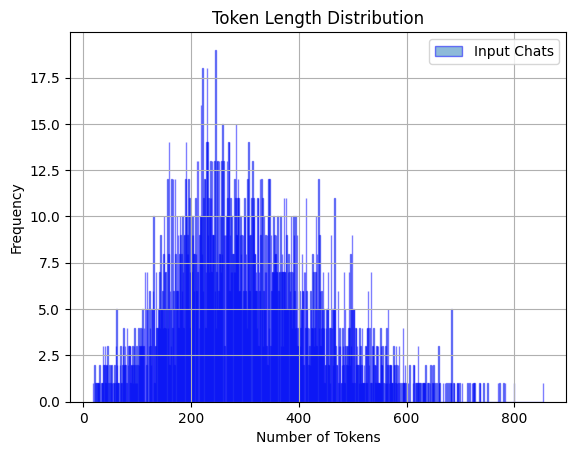

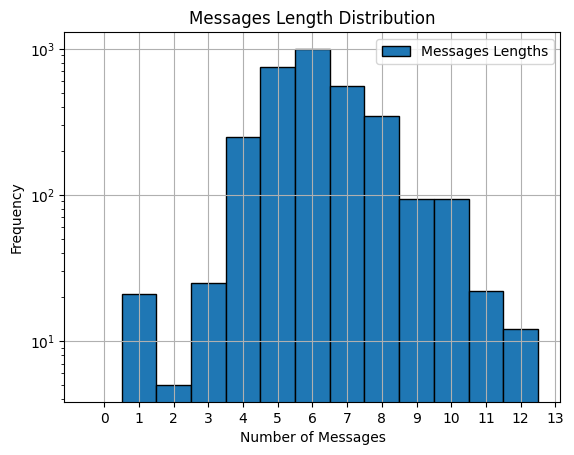

In [25]:
df = DataFrame(tokenized_dataset)

more_than_1024_input_mask = df['input_ids'].apply(lambda x: len(x) > 1024)
more_than_512_input_mask = df['input_ids'].apply(lambda x: len(x) > 512)

# print(f"Tokenized dataset:\n{df.head()}")
print("input_ids token length statistics:")
print(f"Number of samples with more than 1024 tokens: {len(df[more_than_1024_input_mask])}")
print(f"Number of samples with more than 512 tokens: {len(df[more_than_512_input_mask])}")

# plots histograms for input_ids and labels with different colors in a single plot
# with semi-transparent bars in order to visualize overlaps
# with 1024 + 1 bins where the last bin is for samples with more than 1024 tokens

input_ds_token_lengths = df['input_ids'].apply(lambda x: len(x))

input_ds_token_lengths.hist(bins=input_ds_token_lengths.max(), edgecolor='blue', alpha=0.5, label='Input Chats')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
# plt.savefig(os.path.join(OUT_DIR, "token_and_message_length_distribution.png"))
plt.show()

# min_msgs = df['msgs_lengths'].min()
max_msgs = df['msgs_lengths'].max()
df['msgs_lengths'].hist(
    bins=range(max_msgs + 1),  # +2 so last bin includes max
    edgecolor='black',
    label='Messages Lengths',
    align='left'
)
plt.xlabel('Number of Messages')
plt.ylabel('Frequency')
plt.title('Messages Length Distribution')
plt.legend()
# plt.savefig(os.path.join(OUT_DIR, "messages_length_distribution.png"))
plt.yscale('log')
plt.xticks(range(max_msgs + 1))
plt.show()

# Remove all samples with more than 1024 tokens in input_ids and labels
df = df[~more_than_512_input_mask]

# Splitting the Dataset

In [ ]:
print(f"Users in dataset: {df['user_ids'].nunique()}")
print(f"Dataset size: {len(df)}\n")

df.drop(columns=['msgs_lengths'], inplace=True)

# Split the dataset into train, test, and eval sets using user_ids grouped examples
grouped = df.groupby('user_ids')#.size().reset_index(name='counts')
user_ids = list(grouped.groups.keys()) #[:10]
# df = df[df['user_ids'].isin(user_ids)]

train_ids, test_ids = train_test_split(user_ids, test_size=TEST_SIZE, random_state=42)
train_ids, eval_ids = train_test_split(train_ids, test_size=TEST_SIZE, random_state=42)
tokenized_train_set = df[df['user_ids'].isin(train_ids)]
tokenized_test_set = df[df['user_ids'].isin(test_ids)]
tokenized_eval_set = df[df['user_ids'].isin(eval_ids)]

# Prints how many users are in each set
print(f"Users in train set: {tokenized_train_set['user_ids'].nunique()}")
print(f"Users in test set: {tokenized_test_set['user_ids'].nunique()}")
print(f"Users in eval set: {tokenized_eval_set['user_ids'].nunique()}\n")

# Remove the 'user_ids' column from the train, test, and eval sets
tokenized_train_set = tokenized_train_set.drop(columns=['user_ids'])
tokenized_test_set = tokenized_test_set.drop(columns=['user_ids'])
tokenized_eval_set = tokenized_eval_set.drop(columns=['user_ids'])

tokenized_train_set = tokenized_train_set.reset_index(drop=True)
tokenized_test_set = tokenized_test_set.reset_index(drop=True)
tokenized_eval_set = tokenized_eval_set.reset_index(drop=True)

tokenized_train_set = Dataset.from_pandas(tokenized_train_set)
tokenized_test_set = Dataset.from_pandas(tokenized_test_set)
tokenized_eval_set = Dataset.from_pandas(tokenized_eval_set)

print(f"Train set size: {len(tokenized_train_set)}")z
print(f"Test set size: {len(tokenized_test_set)}")
print(f"Eval set size: {len(tokenized_eval_set)}\n")

# Set the format to PyTorch tensors
tokenized_train_set.set_format("torch")
tokenized_test_set.set_format("torch")
tokenized_eval_set.set_format("torch")

print_dataset_info(tokenized_train_set)

Users in dataset: 111
Dataset size: 2918

Users in train set: 70
Users in test set: 23
Users in eval set: 18

Train set size: 1866
Test set size: 598
Eval set size: 454

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1866
})
input_ids: tensor([ 8925, 17687,  1587,  2009,  7089,  1307,  4933, 20177,   153,  5552,
          697,   569,  1332,   120,   141,   228,  1553,   120,   677,   156,
          290,   697,   102,   103, 21882,   650,  7174,  1587,  2009,  8925,
          697,  1041,   543,   697, 17169,   116,   697,   102,   103,  8925,
        17687,  1587,  1141,   697,   665,  6458,  3841,   697,   102,   103,
        21882,   650,  7174,  1587,   913,  1307,   111,  3841,   697,   102,
          103,  8925, 17687,  1587,  7089,  1307,   288,   111,   786,   697,
        12550,   697,   102,   103, 21882,   650,  7174,  1587, 12550,  1307,
         2662,   697,   102,   103,  8925, 17687,  1587,  2009,  7089,  1307,
          

# Training BERT for Regression

In [ ]:
data_collator = DataCollatorForPolarity(tokenizer=tokenizer)

model = BertForRegression.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=1, # our task is regression (num_labels=1).
    cls_token_id=tokenizer.cls_token_id,  # Pass the CLS token ID to the model
)

# loaded_model = BertForRegression.from_pretrained(
#     ".\\out\\models\\BERT\\2025-07-31_09-53-11\\checkpoint-40",
#     num_labels=1,  # our task is regression (num_labels=1).
#     cls_token_id=tokenizer.cls_token_id,  # Pass the CLS token ID to the model
# ).to(DEVICE)

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=BODY_LR,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_PERCENTAGE,
    fp16=torch.cuda.is_available(),
    eval_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=SAVE_TOTAL_LIMIT,
    save_strategy="epoch",
    logging_strategy="epoch",
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_num_workers=NUM_WORKERS,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_eval_set,
    # tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

plot_losses(trainer.state.log_history, RESULTS_PATH)

Some weights of BertForRegression were not initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Testing the Model

## Inference Example

In [ ]:
# def inference(model, chat):
#     tokenized_chat = tokenizer(
#         chat,
#         truncation=True,
#         max_length=512,
#         return_tensors='pt'
#     )
#     tokenized_chat = {k: v.to(DEVICE) for k, v in tokenized_chat.items()}
    
#     model.eval()
#     with torch.no_grad():
#         outputs = model(**tokenized_chat)
    
#     logits = outputs.logits.squeeze()
#     return logits

# # Example inference
# chat = '''
# Mauro:
# Ei, come va?
# Maria:
# Ciao Mauro! Tutto bene, grazie! E tu?
# Mauro:
# Tutto ok, grazie! Che fai di bello oggi?
# Maria:
# Sinceramente non lo so, ho un po' di cose da fare ma non so da dove cominciare. Tu che fai?
# '''
# logits = inference(model, chat)
# print(f"Inference logits: {logits}")

## Evaluating the Model

In [ ]:
test_metrics = trainer.evaluate(eval_dataset=tokenized_test_set)
for key, value in test_metrics.items():
    print(f"{key}: {value}")
with open(os.path.join(RESULTS_PATH, "test_metrics.txt"), "w") as f:
    for key, value in test_metrics.items():
        f.write(f"{key}: {value}\n")